# Volpriehausen Formation Analysis: Data extraction

This notebook reads porosity and permeability data, filters for Volpriehausen formations, and provides statistical summaries.

### Import required libraries

In [34]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io

### Load data set

In [35]:
# Download and extract CSV from ZIP
url = "https://www.nlog.nl/sites/default/files/2025-12/thematische_data_boringen.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("nlog_poroperm_20251204.csv") as f:
        df = pd.read_csv(f, sep=';')

### Filter for Volpriehausen formations

In [36]:
# Extract unique formations
schichten = df[["STRAT_UNIT_NM", "STRAT_UNIT_CD"]].drop_duplicates().copy()

# Filter for "Volpriehausen"
volprihausen = schichten[schichten["STRAT_UNIT_NM"].astype(str).str.contains("Volpriehausen")].copy()

print("Filtered Volpriehausen formations:")
print(volprihausen)

Filtered Volpriehausen formations:
                              STRAT_UNIT_NM STRAT_UNIT_CD
3352                Volpriehausen Formation          RBMV
8186    Volpriehausen Clay-Siltstone Member         RBMVC
8235   Lower Volpriehausen Sandstone Member         RBMVL
9865   Upper Volpriehausen Sandstone Member         RBMVU
26152          Volpriehausen Avicula member         RBMVA


#### Output: All Volpriehausen formations with STRAT_UNIT_CD

In [37]:
# Remove specific codes
volprihausen = volprihausen[~volprihausen["STRAT_UNIT_CD"].isin(["RBMVC", "RBMVA"])]

print("Filtered Volpriehausen formations:")
print(volprihausen)

Filtered Volpriehausen formations:
                             STRAT_UNIT_NM STRAT_UNIT_CD
3352               Volpriehausen Formation          RBMV
8235  Lower Volpriehausen Sandstone Member         RBMVL
9865  Upper Volpriehausen Sandstone Member         RBMVU


### Filter main dataset and calculate derived fields

In [38]:
# Filter main dataset
df2 = df[df['STRAT_UNIT_NM'].isin(volprihausen['STRAT_UNIT_NM'])].copy()

# Calculate thickness
df2.loc[:, "THICKNESS"] = df2["BOTTOM_STRAT"] - df2["TOP_STRAT"]

df2.loc[:, "LogK"] = np.log10(df2["HOR_PERMEABILITY"])

#### Output: Statistics for the filtered data

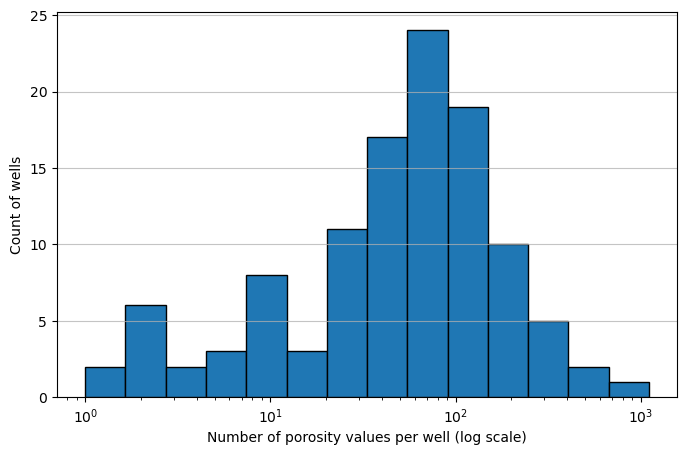

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Histogram: Number of samples per well (logarithmic x-axis and bins)
n_per_well = df2.groupby('SHORT_NM')['POROSITY'].count()
n_per_well = n_per_well[n_per_well > 0]  # Remove wells with no porosity values
min_val = n_per_well.min()
max_val = n_per_well.max()
# Use log-spaced bins
bins = np.logspace(np.log10(min_val), np.log10(max_val), num=15)
plt.figure(figsize=(8, 5))
plt.hist(n_per_well, bins=bins, edgecolor='black', log=False)
plt.xscale('log')
plt.xlabel('Number of porosity values per well (log scale)')
plt.ylabel('Count of wells')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [40]:
df2.describe()

,UWI,DEPTH,POROSITY,HOR_PERMEABILITY,GRAIN_DENSITY,VERT_PERMEABILITY,FORMATION_FACTOR,TOP_STRAT,BOTTOM_STRAT,THICKNESS,LogK
count,11450.000000,11450.000000,10678.000000,9315.000000,10469.000000,2034.000000,29.000000,11450.000000,11450.000000,11450.000000,9315.000000
mean,6557.158428,2963.222721,12.690894,123.727912,2.670635,56.289246,111.569310,2938.926931,2998.861572,59.934641,0.475780
std,2223.313228,826.145155,6.289204,512.352452,0.044659,207.814685,68.622694,831.105814,821.486251,28.765862,1.485720
min,1071.000000,1387.100000,0.010000,0.001000,2.000000,0.003000,10.030000,1387.000000,1475.000000,10.000000,-3.000000
25%,4190.000000,2435.400000,8.000000,0.150000,2.643000,0.090000,52.000000,2414.580000,2489.000000,39.000000,-0.823909
50%,7422.000000,3123.000000,12.000000,2.600000,2.670000,0.463000,123.500000,3097.000000,3173.000000,56.000000,0.414973
75%,8337.000000,3642.187500,17.200000,59.150000,2.700000,20.425000,155.000000,3633.000000,3673.500000,68.500000,1.771953
max,9302.000000,4548.900000,32.300000,25578.000000,2.980000,3167.530000,233.000000,4530.000000,4565.000000,181.900000,4.407867


In [41]:
df2.head()

,NITG_NR,UWI,SHORT_NM,DEPTH,POROSITY,HOR_PERMEABILITY,GRAIN_DENSITY,VERT_PERMEABILITY,FORMATION_FACTOR,ANALYSIS_NR,...,LAB,LAB_NR,LAB_REPORT_DATE,REMARK,TOP_STRAT,BOTTOM_STRAT,STRAT_UNIT_CD,STRAT_UNIT_NM,THICKNESS,LogK
3352,BP100068,8834,P10-05,2255.58,22.9,229.0000,2.6400,NaN,NaN,3V,...,COREX,2007-032A,2007-08-31 00:00:00.000,NaN,2246.0,2427.9,RBMV,Volpriehausen Formation,181.9,2.359835
3353,BP100068,8834,P10-05,2255.71,20.4,NaN,2.6500,NaN,NaN,4,...,COREX,2007-032A,2007-08-31 00:00:00.000,NaN,2246.0,2427.9,RBMV,Volpriehausen Formation,181.9,NaN
8235,B30E0306,4173,VAL-01,2873.10,8.9,0.0902,2.6921,NaN,NaN,NM0158,...,NAM,NaN,NaN,NaN,2873.0,2921.0,RBMVL,Lower Volpriehausen Sandstone Member,48.0,-1.044793
8236,B30E0306,4173,VAL-01,2873.40,9.1,0.0800,2.6965,NaN,NaN,NM0159,...,NAM,NaN,NaN,NaN,2873.0,2921.0,RBMVL,Lower Volpriehausen Sandstone Member,48.0,-1.096910
8237,B30E0306,4173,VAL-01,2873.60,7.3,0.0304,2.7191,NaN,NaN,NM0160,...,NAM,NaN,NaN,NaN,2873.0,2921.0,RBMVL,Lower Volpriehausen Sandstone Member,48.0,-1.517126


### Export filtered data

In [42]:
df2.to_excel("poroperm_volpriehausen.xlsx")
print("Data successfully exported to 'poroperm_volpriehausen.xlsx'.")

Data successfully exported to 'poroperm_volpriehausen.xlsx'.
